In [1]:
from datasets_2 import create_downstream_dataset

C:\Users\erik2\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    task = "vqav2"
    model = "beit3_base_patch16_224_mini_vqav2"
    batch_size = 8
    sentencepiece_model = "./beit3.spm"
    data_path = "./data"
    input_size = 224
    train_interpolation = 'bilinear'
    randaug = False
    num_max_bpe_tokens = 128
    num_workers = 1
    pin_mem = True
    dist_eval = False

In [3]:
data_loader_train, data_loader_val = create_downstream_dataset(Args())

Load 434867 image-text pairs from ./data\vqa.train.jsonl. 
Load 204944 image-text pairs from ./data\vqa.trainable_val.jsonl. 
Load 5107 image-text pairs from ./data\vqa.rest_val.jsonl. 


In [4]:
x = next(iter(data_loader_train))

In [5]:
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer("./beit3.spm")

In [13]:
from timm.models import create_model
import utils
import modeling_finetune

model = create_model(
    "beit3_base_patch16_224_pipi_vqav2",
    pretrained=False,
    drop_path_rate=0.1,
    vocab_size=64010,
    checkpoint_activations=None,
)

utils.load_model_and_may_interpolate("./save_tiny/checkpoint-best.pth", model, "model|module", '')
model = model.to('cuda:0')

Load ckpt from ./save_tiny/checkpoint-best.pth
Load state_dict by model_key = model


In [14]:
from torch.utils.data import DataLoader
from cka import CKA

dataloader = DataLoader(data_loader_val, batch_size=8, shuffle=False)

In [17]:
cka = CKA(model, model,
          model1_name="MiniBeit3",   # good idea to provide names to avoid confusion
          model2_name="MiniBeit3",   
          model1_layers= [
                            "beit3.encoder.layers.0.final_layer_norm.A",
                            "beit3.encoder.layers.0.final_layer_norm.B",
                            "pooler",
                            "head.1",
                            "head.3"
                            ],
                        model2_layers= [
                            "beit3.encoder.layers.0.final_layer_norm.A",
                            "beit3.encoder.layers.0.final_layer_norm.B",
                            "pooler",
                            "head.1",
                            "head.3"
                            ],
          device='cuda')


c:\Users\erik2\Documents\Github\MUCSI_Modal\beit-3\cka.py:64: UserWarning: Both model have identical names - MiniBeit3. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \


In [18]:
cka.compare(dataloader.dataset)

c:\Users\erik2\Documents\Github\MUCSI_Modal\beit-3\cka.py:158: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")


num_batches  638


| Comparing features |: 100%|██████████| 638/638 [00:59<00:00, 10.81it/s]


In [19]:
results = cka.export() 

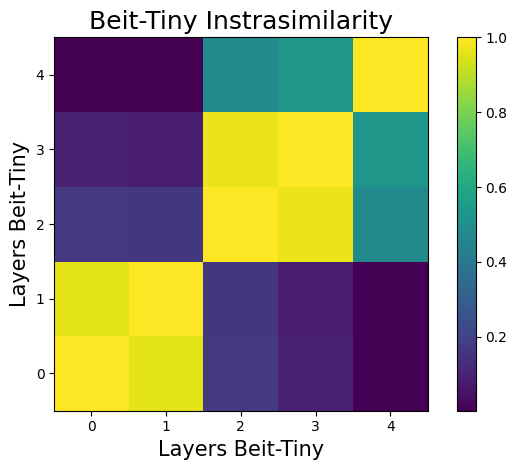

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(results['CKA'], origin='lower')
ax.set_xlabel(f"Layers Beit-Tiny", fontsize=15)
ax.set_ylabel(f"Layers Beit-Tiny", fontsize=15)

ax.set_title(f"Beit-Tiny Instrasimilarity", fontsize=18)

# Add colorbar
cbar = fig.colorbar(im)

plt.tight_layout()
plt.show()
